In [1]:
#HIDE
try:
    import setup
except:
    pass
from notebook_helper import *
notebook_setup()
from modules import la

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Pullution cluster: kitchen sink edition

What happens if we just use *all* the variables avalaible in the BEIS data? Looks like the result is fine, but a lot more complicated to interpret.  

In [2]:
data_year = 2019

df = pd.read_excel(Path("data", "2005-19_UK_local_and_regional_CO2_emissions.xlsx"),
                   sheet_name="Subset dataset", header=1)
df = df.loc[df["Year"] == data_year].loc[~df["Code"].isna()]
df = df[df.columns[3:-4]]
df = df.drop(columns="Year")

df = (df
      .la.create_code_column(from_type="gss", source_col="Code")
      .drop(columns=["Code"])
      .la.to_current()
      .la.just_lower_tier())

higher_df = df.la.to_higher(aggfunc="sum")

df = pd.concat([df, higher_df])
df = df.set_index("local-authority-code")
df.columns = [x.strip() for x in df.columns]
original = list(df.columns)

In [5]:
used_cols = [x for x in original if "Total" not in x]
 
ndf = df[used_cols]

ndf = ndf.reset_index().la.get_council_info(["region", "pop-2020"])

#convert to per capita emissions
for c in used_cols:
      ndf[c] = (ndf[c]/ndf["pop-2020"])*100

ndf = ndf.drop(columns=["pop-2020"])
ndf["region"] = ndf["region"].fillna("Unknown")
ndf = ndf.set_index("local-authority-code")
ndf.head()

,Industry Electricity,Industry Gas,Industry 'Other Fuels',Large Industrial Installations,Agriculture,Commercial Electricity,Commercial Gas,Commercial 'Other Fuels',Public Sector Electricity,Public Sector Gas,Public Sector 'Other Fuels',Domestic Electricity,Domestic Gas,Domestic 'Other Fuels',Road Transport (A roads),Road Transport (Minor roads),Transport Other,region
local-authority-code,,,,,,,,,,,,,,,,,,
ABC,0.04,4.44e-02,0.09,0.00e+00,3.13e-02,0.02,1.38e-03,1.49e-03,3.48e-03,3.67e-05,8.79e-04,0.03,0.01,1.34e-01,0.11,0.09,1.20e-03,Northern Ireland
ABD,0.02,1.06e-02,0.04,5.04e-04,3.98e-02,0.03,1.09e-02,1.06e-03,4.15e-03,3.60e-03,4.40e-04,0.04,0.08,6.48e-02,0.15,0.09,1.22e-03,Scotland
ABE,0.02,1.05e-02,0.04,0.00e+00,1.41e-03,0.04,3.08e-02,2.71e-04,8.45e-03,3.36e-02,3.40e-04,0.03,0.11,3.34e-03,0.07,0.06,1.22e-02,Scotland
ADU,0.01,3.47e-03,0.01,0.00e+00,1.14e-03,0.01,1.14e-02,7.14e-05,2.37e-03,4.31e-03,1.73e-05,0.03,0.09,5.21e-03,0.08,0.04,2.02e-02,South East
AGB,0.02,1.38e-03,0.07,0.00e+00,3.77e-02,0.03,1.93e-02,2.62e-03,6.98e-03,9.94e-03,1.25e-03,0.06,0.07,5.33e-02,0.17,0.04,2.56e-03,Scotland


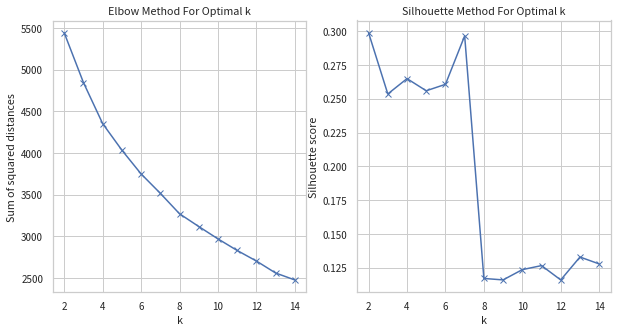

In [7]:
cdf = ndf.drop(index=["LND"]).reset_index()
cluster = cdf.space.cluster("local-authority-code", cols=used_cols, normalize=True)
cluster.find_k(2,15)

In [8]:
# seems to be a cluster preference for 7

cluster.set_k(7).stats()

,count,%,random members
labels,,,
1,250,62.5,"[TFW, CRY, NOW, FAR, EPP]"
2,52,13.0,"[RUT, BAE, NLN, VAL, FLN]"
3,5,1.2,"[FMO, ELS, ZET, ORK, MUL]"
4,10,2.5,"[WSM, CLK, SLG, KEC, OXO]"
5,1,0.2,[IOS]
6,76,19.0,"[MAV, CRA, DEN, TEI, BAB]"
7,6,1.5,"[CHW, NEL, STT, NEW, LBC]"


Broadly these clusters seem to isolate islands in their own clusters, and then create a few groups that aren't the 'mainstream' group 3. 

This is probably isolating a few more things, but isn't creating 'clear' clusters for the majority of councils, and is harder to explain the differences. 